# A/B тестирование конверсии 

__Обзор на кейс:__

Компания X занимается продажей товаров. Было решено поменять дизайн главной страницы. 

__Цель тестирования:__ узнать, поменяется ли конверсия на новой странице.

Датасет состоит из следующей информации:

1. __user_id__: уникальный идетнификатор пользователя.
2. __timestamp__: дата записи данных о пользователе в датасет.
3. __group__: группа пользователя в эксперименте.
4. __landing_page__: страница, которую видел пользователь во время эксперимента.
5. __converted__: совершил ли пользователь целевое действие.

## Чтение, проверка и трансформация данных

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [5]:
ab_data = pd.read_csv(r'data\ab_data.csv')

In [6]:
ab_data.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
ab_data.shape 

(294478, 5)

In [8]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Видно, что нулевые значение отстутсвуют.

In [9]:
#Проверка на наличие повторных записей для одного и того же пользователя
ab_data['user_id'].duplicated().sum()

3894

In [10]:
#Удаление дупликатов
ab_data.drop_duplicates(['user_id'],inplace=True)

Проверка на наличие ошибок в записях:
1. Пользователи контрольной группы, увидевшие новую страницу
2. Пользователи тестовой группы, увидевшие старую страницу

In [11]:
ab_data.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1006       1006       1006
          old_page       144226     144226     144226
treatment new_page       144314     144314     144314
          old_page         1038       1038       1038

In [12]:
#Удаление некоректных данных
ab_cleaned = ab_data.loc[( ab_data['group'] == 'control') & ( ab_data['landing_page'] == 'old_page') | ( ab_data['group'] == 'treatment') & ( ab_data['landing_page'] == 'new_page')]

In [13]:
ab_cleaned.shape

(288540, 5)

## Разведочный анализ данных (EDA)

In [14]:
#Таблица сопряженности 
pd.crosstab(index=ab_cleaned['group'], columns=ab_cleaned['converted'], margins=True)

converted,0,1,All
group,,,
control,126877,17349,144226
treatment,127180,17134,144314
All,254057,34483,288540


In [15]:
#Разделение данных по группам
control = ab_cleaned[ab_cleaned['group'] == 'control']
treatment = ab_cleaned[ab_cleaned['group'] == 'treatment']

In [20]:
#Расчет показателей конверсии
conv_rate_control = control.converted.sum()/control.converted.count()
conv_rate_treatment = treatment.converted.sum()/treatment.converted.count()
conv_diff = conv_rate_control-conv_rate_treatment
print("Конверсия старой страницы: ",conv_rate_control,'\nКонверсия новой страницы: ',conv_rate_treatment,'\nРазница конверсий:',conv_diff)

Конверсия старой страницы:  0.12029037760181936 
Конверсия новой страницы:  0.11872721981235362 
Разница конверсий: 0.0015631577894657384


## AB test

__Определение гипотез:__

*__H0__* = Конверсия на новой и на старой странице не различается 

*__H1__* = Конверсия на новой и на старой странице различается

Определим уровень статистической значимости: *α* = *__0,05__*

__Переменные:__

Для анализа присутствуют только номинативные переменные, такие как группа (контрольная и тестовая) и конверсия(действие 
произошло - 1,не произошло - 0). 

В связи с этим для анализа будут использован непараметрический метод - Хи-квадрат Пирсона.

In [21]:
#Подготовка данных 
c_conv = control.converted.sum()
c_noconv = control.converted.size - control.converted.sum()
t_conv = treatment.converted.sum()
t_noconv = treatment.converted.size - treatment.converted.sum()
print(c_conv,c_noconv,t_conv,t_noconv)

17349 126877 17134 127180


In [29]:
obs = np.array([[c_conv,c_noconv],[t_conv,t_noconv]])
obs

array([[ 17349, 126877],
       [ 17134, 127180]], dtype=int64)

### Метод Хи-квадрат Пирсона

Это непараметрический метод, который позволяет оценить значимость различий между фактическим количеством исходов или качественных характеристик выборки, попадающих в каждую категорию, и теоретическим количеством, которое можно ожидать в изучаемых группах при справедливости нулевой гипотезы.

χ2 рассчитывается по следующей формуле:

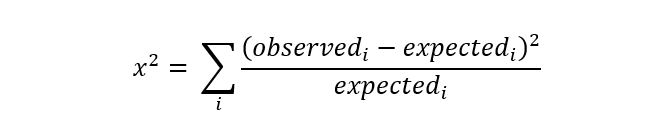

Где *odserved* - полученные значения, а *expected* - ожидаемые. 

Так же, требуется знать число степеней свободы, которое находится по формуле: 

__dof__ = (число строк смежной таблицы - 1 )*(число столбцов смежной таблицы - 1)

Далее сравнивается χ2 с критическим при при числе степеней свободы dof. Если полученное значение χ2 больше критического, при соответсвующем уровне значимости, делаем вывод о статистической значимости изменений и принимаем альтернативную гипотезу.

In [37]:
#Применяем метод Хи-квадрат Пирсона 
chi2, p_value, dof, ex = stats.chi2_contingency(obs, correction=False)
p_value

0.1955836428788163

# Вывод

Рассчитанное p-value ~ 0.195, при α = 0.05, означает что статистически значимих различий не найдено. Оставляем нулевую гипотезу.